In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

# AppStore-analystics

#### פרוייקט 24

#### https://www.kaggle.com/datasets/ramamet4/app-store-apple-data-set-10k-apps?resource=download

##### מגישים:
##### איתי שם טוב
##### מיכאל שמריה
##### אבי בן דוד
##### יפעת קצבורג

<a id='top'></a>

<div>
<img src="https://raw.githubusercontent.com/aviben9/AppStore/main/Apple_logo_black.svg" width="150"/>
</div>

1. [Missing values](#section1)
2. [prices](#section2)

   2.1 [paid/free](#section2.1)

   2.2 [paid/unpaid compare](#section2.2)

   2.3 [User Ratings for Paid and Free Apps](#section2.3)
3.[sizes](#section3)

   3.1 [language number](#section3.1)

   3.2 [language number to rating](#section3.2)

4.[prediction](#section4)

   4.1 [Accuracy prediction](#section4.1) 
   
   4.2 [feature_importances](#section4.2) 



#### information on the data
הדאטה שלנו מבוסס על חנות האפליקציות של אפל, אנחנו מעוניינים להציג לטים קוק  באיזה אפליקציות כדאי לו להשקיע יותר ובמה להשקיע פחות 

In [50]:
url = 'https://raw.githubusercontent.com/aviben9/AppStore/main/AppleStore%20(2).csv'
apps = pd.read_csv(url)
apps.head(3)

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1


<a id='section1'></a>
### 1. Change values ​​as needed and Missing values

[back to top](#top)

In [52]:
apps['size_bytes'] = apps['size_bytes'] / (1024 * 1024)
apps = apps.rename(columns={'size_bytes': 'Size_MB','lang.num':'lang_num'})
apps.head()

,Unnamed: 0,id,track_name,Size_MB,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang_num,vpp_lic
0,1,281656475,PAC-MAN Premium,96.119141,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,151.232422,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",95.867188,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",122.558594,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,88.476562,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [4]:
apps.isnull().sum().sort_values(ascending=False)

Unnamed: 0          0
user_rating_ver     0
lang_num            0
ipadSc_urls.num     0
sup_devices.num     0
prime_genre         0
cont_rating         0
ver                 0
user_rating         0
id                  0
rating_count_ver    0
rating_count_tot    0
price               0
currency            0
Size_MB             0
track_name          0
vpp_lic             0
dtype: int64

כמו שניתן לראות - לא קיימים ערכים חסרים

<a id='section2'></a>
### 2. prices
[back to top](#top)

אנחנחו מעוניינים לרדת לעומק הדאטה, לחלק שהכי מסקרן- המחירים


<a id='section2.1'></a>
### 2.1 paid/free

נוסיף עמודה של ערכים בינארים המייצגים את השאלה אם האפליקציה עולה כסף - כן או לא, כדי שנוכל לחקור באופן מדוייק יותר את השאלות שעולות

,free_non,Count
0,0,4056
1,1,3141


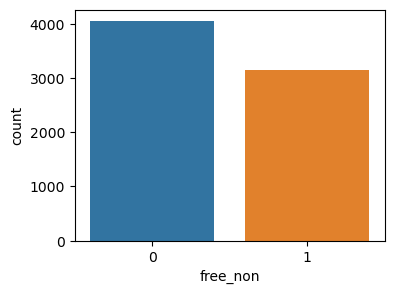

In [5]:
apps['free_non'] = apps['price'].apply(lambda x : 1 if x > 0 else 0)
price_ft = apps.groupby(['free_non']).size().sort_values(ascending=False).reset_index(name='Count')
plt.figure(figsize=(4, 3))
sns.countplot(x='free_non', data=apps)
price_ft

In [6]:
free_apps=apps[(apps.price==0)]
paid_apps=apps[(apps.price>0)]
free = free_apps.prime_genre.value_counts().sort_index().to_frame()
paid = paid_apps.prime_genre.value_counts().sort_index().to_frame()
total = apps.prime_genre.value_counts().sort_index().to_frame()
free.columns=['free']
paid.columns=['paid']
total.columns=['total']
fig  =free.join(paid).join(total)
fig['%paid'] = fig.paid*100 /fig.total
fig['%free'] = fig.free*100/ fig.total
fig = fig.sort_values('paid')
fig

,free,paid,total,%paid,%free
Catalogs,9,1,10,10.000000,90.000000
Shopping,121,1,122,0.819672,99.180328
Medical,8,15,23,65.217391,34.782609
News,58,17,75,22.666667,77.333333
Finance,84,20,104,19.230769,80.769231
Food & Drink,43,20,63,31.746032,68.253968
Social Networking,143,24,167,14.371257,85.628743
Travel,56,25,81,30.864198,69.135802
Navigation,20,26,46,56.521739,43.478261
Sports,79,35,114,30.701754,69.298246


<a id='section2.2'></a>
### 2.2 paid/unpaid compare

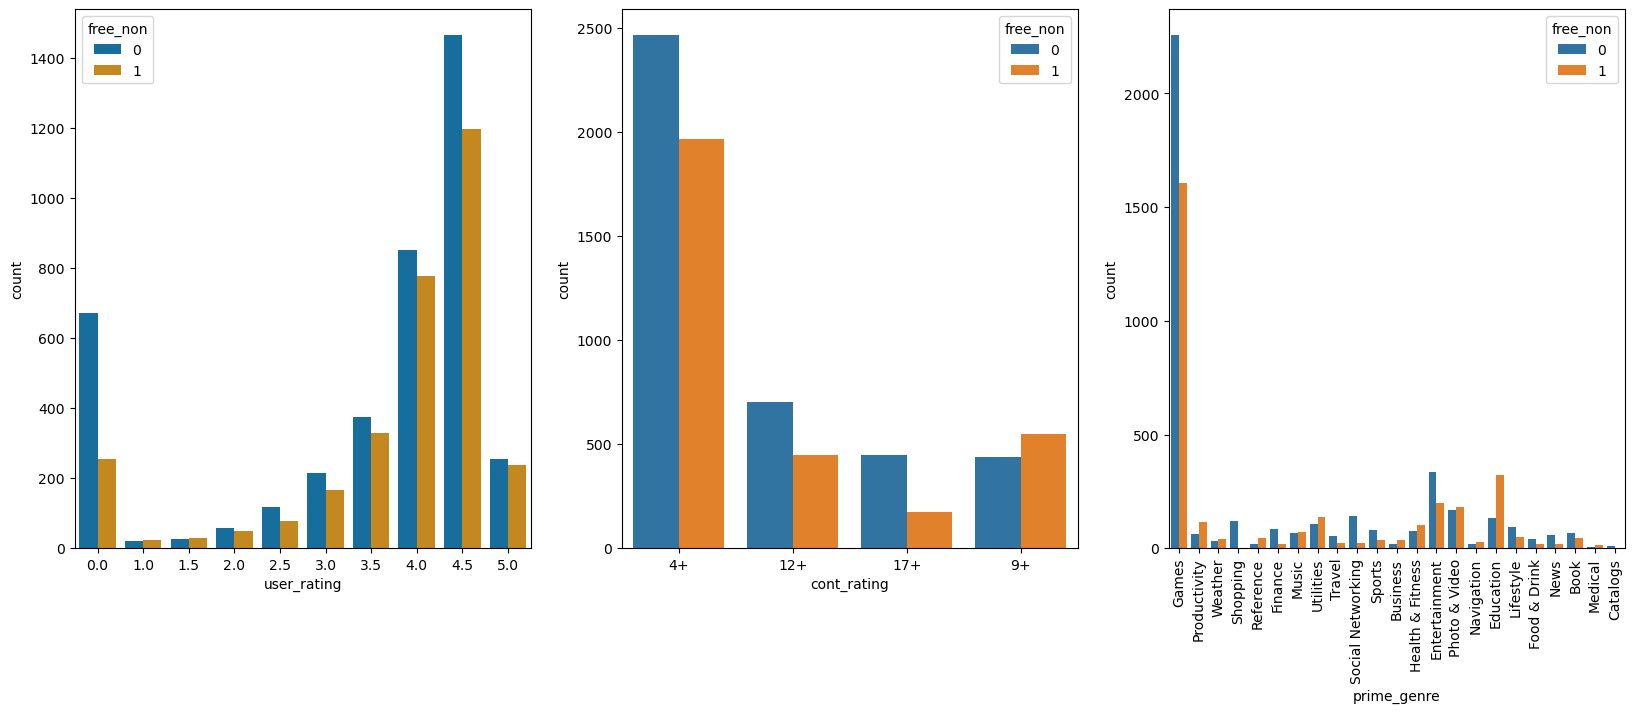

In [7]:
fig, ax =plt.subplots(ncols=3, figsize=(20, 7))
sns.countplot(data=apps,x='user_rating',hue='free_non',ax=ax[0],palette='colorblind')
sns.countplot(data=apps,x='cont_rating',hue='free_non',ax=ax[1])
sns.countplot(data=apps,x='prime_genre',hue='free_non',ax=ax[2])
plt.xticks(rotation=90)
plt.show()

כאן ניתן לראות את הקשרים בין האפליקציות החינמיות והאפליקציות בתשלום לבין העמודות של הגילים, הרייטינג וסוג האפליקציה

<a id='section2.3'></a>
### 2.3 User Ratings for Paid and Free Apps



האם זה נכון שבחיינו אנחנו יותר ביקורתיים על מוצרים שעלו לנו כסף ואנחנו בהכרח מצפים מהם ליותר?

In [8]:
paid_avg_user_rating = paid_apps["user_rating"].mean()
print('The average user rating of paid apps is ', round(paid_avg_user_rating, 2))

free_apps = apps.loc[apps['price'] == 0.00]
free_avg_user_rating = free_apps["user_rating"].mean()
print('The average user rating of free apps is ', round(free_avg_user_rating, 2))

The average user rating of paid apps is  3.72
The average user rating of free apps is  3.38


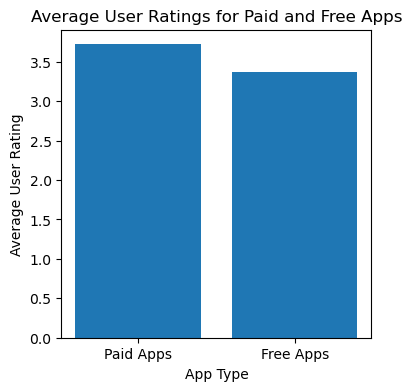

In [9]:
plt.figure(figsize=(4, 4))
categories = ['Paid Apps', 'Free Apps']
avg_ratings = [paid_avg_user_rating, free_avg_user_rating]
plt.bar(categories, avg_ratings)
plt.xlabel('App Type')
plt.ylabel('Average User Rating')
plt.title('Average User Ratings for Paid and Free Apps')
plt.show()



>##### Observation 1:
 הציפיה שלנו הייתה לראות שממוצע הדירוגים של אפליקציות שעולות כסף יהיה נמוך מהחינמיות כי באופן טבעי נהיה יותר ביקורתיים כלפי משהו שהוצאנו עליו כסף ונצפה ממנו להרבה יותר המסקנה שלנו היא דווקא להשקיע באפליקציות בתשלום (ולא בהכרח בחינמיות עם פרסומות) ואפילו לבחון את האופציה בהוספת אפליקציות בתשלום ולהשקיע בהן יותר מאמץ מהחינמיות  

#**שלב שני**

<a id='section3'></a>
## 3. sizes
[back to top](#top)


<a id='section3.1'></a>
### 3.1 language number


 האם כדאי להשקיע בתרגום של אפליקציות?

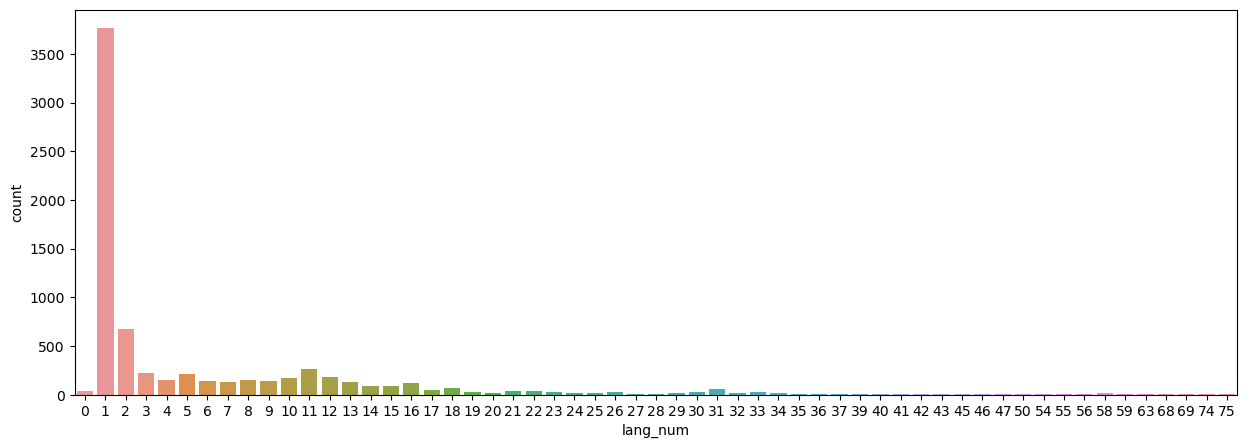

In [10]:
plt.figure(figsize=(15,5))
sns.countplot(data=apps,x='lang_num')
plt.show()

מהגרף מאוד ברור שרוב האפליקציות בעלות שפה אחת בלבד

האם כדאי להשקיע בתרגום אפליקציות בכדי להעלות את כמות החשיפה?

אם נשקיע בתרגום - האם זה יגדיל את גודל האפליקציה ?

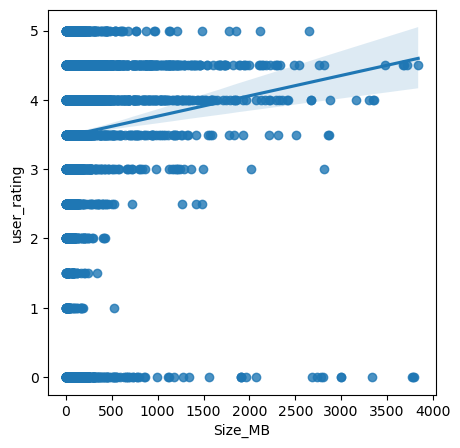

In [11]:
plt.figure(figsize=(5, 5))
sns.regplot(data=apps, y='user_rating', x='Size_MB')
plt.show()

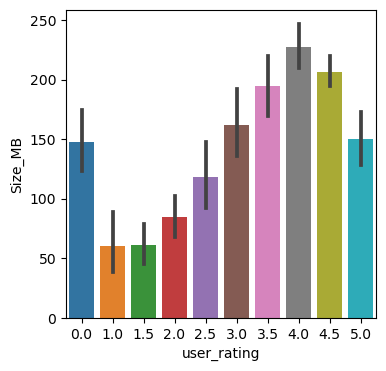

In [12]:
plt.figure(figsize=(4,4))
sns.barplot(x='user_rating', y='Size_MB', data=apps)
plt.show()

##### הנחת היסוד הייתה, שאפליקציה בעלת מספר רב של שפות תגדיל את משקל האפליקציה מה שישפיע כמות הרייטינג (דרך חשיפה ליותר מדינות ומשתמשים).
##### מהתרשימים שהצגנו ניתן לראות כי באמת **אפליקציות עם דירוג גבוה שוקלות הרבה**
אז אולי כן נמליץ על השקעת משאבים בתרגום אפליקציות?

<a id='section3.2'></a>
### 3.2 language number to rating

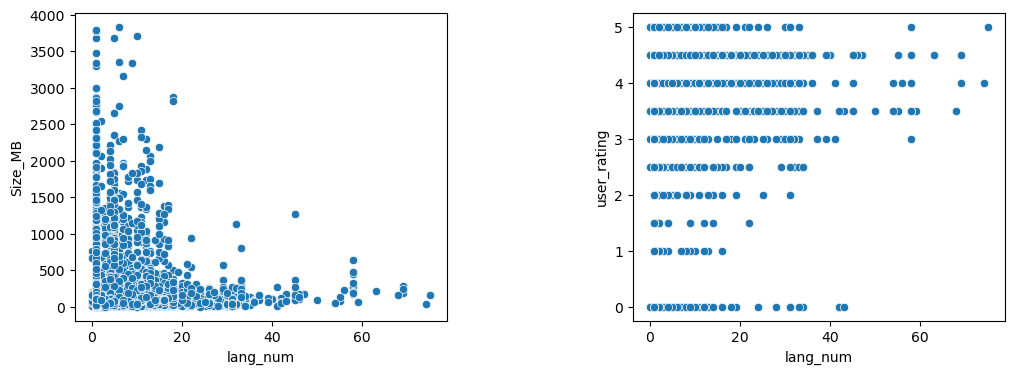

In [13]:
fig, ax = plt.subplots(1,2, figsize = (12,4))
plt.subplots_adjust(wspace = 0.5)

sns.scatterplot(data = apps, x ='lang_num',y='Size_MB',ax = ax[0])
sns.scatterplot(data = apps, x ='lang_num',y='user_rating',ax = ax[1])

plt.show()

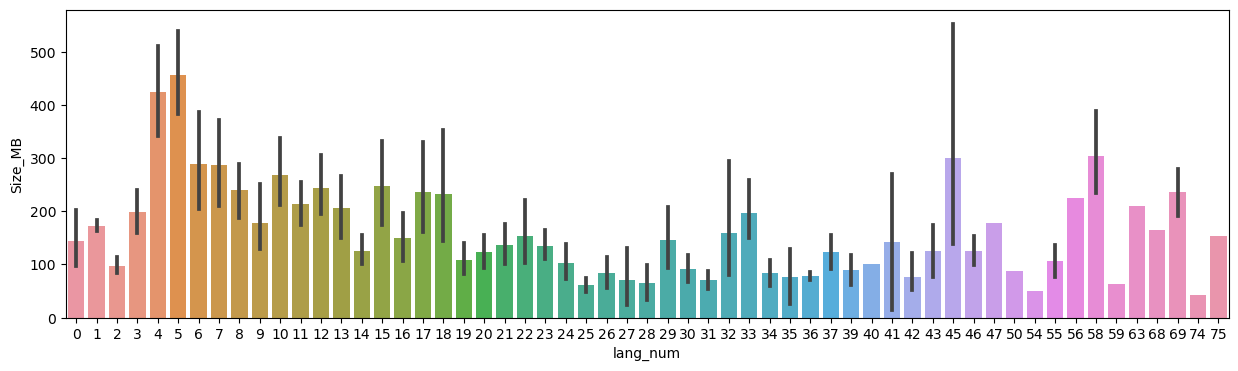

In [14]:
plt.figure(figsize=(15,4))
sns.barplot(x='lang_num',y='Size_MB', data=apps)
plt.show()

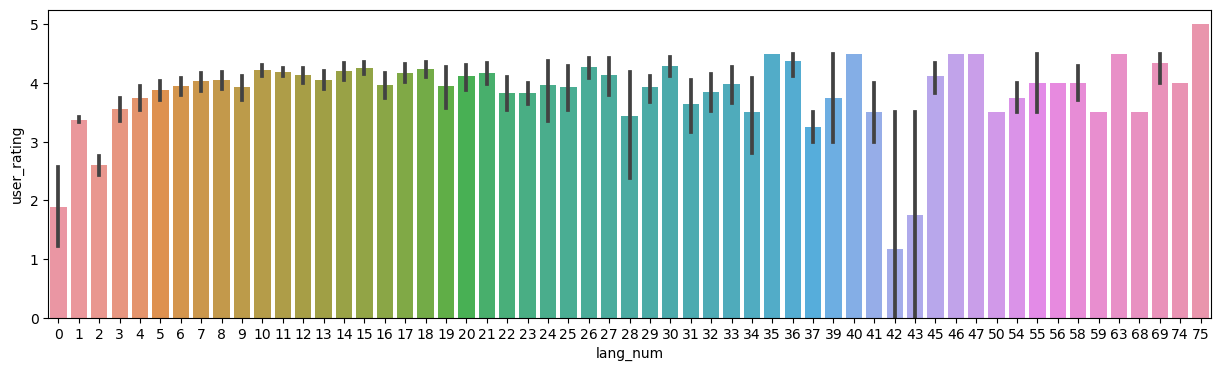

In [15]:
plt.figure(figsize=(15,4))
sns.barplot(x='lang_num',y='user_rating', data=apps)
plt.show()

>##### Observation 2:
ההמלצה שלנו היא שהשקעה בפיתוח של אפליקציה תתמקד יותר באיכות האפליקציה ולא בתרגום של יותר שפות 

#**שלב שלישי**
<a id='section4'></a>
## 4. prediction
[back to top](#top)

<a id='section4.1'></a>
### 4.1 Accuracy prediction


In [16]:
m=apps.loc[apps['price']!=0]
m['price'].mean()

3.955297675899396

##### המחיר הממוצע של אפליקציות בתשלום שמדורגות גבוה (4+) הוא 4$

In [17]:
apps['rating_category'] = apps['price'].apply(lambda x: 'High' if x >= 4 else 'Low')
features=['Size_MB','user_rating','lang_num','ipadSc_urls.num','sup_devices.num']
X = apps[features]
y = apps['rating_category']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

for i in range(40):
    model = DecisionTreeClassifier(random_state=42+i,max_depth=8)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9013888888888889


##### לאחר שסיימנו לבנות עץ חיזוי גילינו שהוא מגיע לרמת דיוק של 90%. עכשיו אם נרצה להכניס
##### אפליקציה חדשה נוכל לקבוע האם היא תהיה אפליקציה "יקרה" או "זולה" - מעל או מתחת ל-4$

<a id='section4.2'></a>
### 4.2 feature_importances

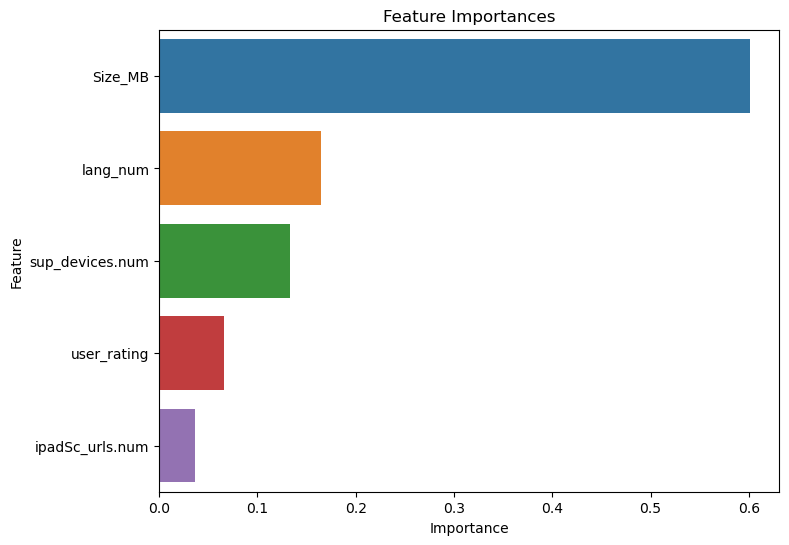

In [18]:
importance_scores = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': features, 'Importance': importance_scores})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

feature_importances

plt.figure(figsize=(8, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


>##### Observation 2:
כאשר מפתחי אפליקציות ירצו להכניס אפליקציות חדשות לאפל סטור נחייב אותם להכניס את גודל האפליקציה ומספר השפות התומכות על מנת שאנו נוכל לבצע חיזוי מדוייק למחיר, וכך נוכל לדעת האם אפליקציה חדשה תהיה שווה לנו כסף או לא


# **סיכום**
##1. **נשקיע יותר באפליקציות בתשלום** להעלאת כמות ההורדות והשימוש של משמתמשים
##2. **לא נשקיע בתרגום שפות** של אפליקציות אך גם **לא נמנע מעדכון והגדלת האפליקציות** מחשש של חוסר שביעות רצון המשתמש מגודלן
##3. **נקפיד על טווח מחירים** מסויים של האפליקציות שבתשלום כדי שנוכל להגיע למספר רב יותר של משתמשים ובנוסף **נקפיד על הזנת נתונים מדוייקים** של האפליקציות (מול יוצרי האפליקציות) ליצירת חיזוי מדוייק להכנסת האפליקציה הבאה!